In [1]:

import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from keras.optimizers import Adam
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [9]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [10]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [11]:
import os
os.chdir("/content/drive/My Drive/text-to-image")
os.listdir()

['model',
 'Flickr8k_Dataset',
 'data',
 'Flickr8k_text',
 'src-juan',
 'src-paola',
 'src-ely',
 'resultados_pasados',
 'pickles',
 'logs',
 'src-clean',
 'ToDo.gdoc',
 'my.png',
 'model.png',
 'random_test',
 '8min.gslides']

## Load Data


In [0]:
from pickle import dump, load

with open("./pickles/FIXED/E_bert_train.pickle","rb") as f:
  emb_train = load(f)

with open("./pickles/FIXED/E_bert_test.pickle","rb") as f:
  emb_test = load(f)

with open("./pickles/FIXED/X_train_64.pickle","rb") as f:
  X_train= load(f)

with open("./pickles/FIXED/X_test_64.pickle","rb") as f:
  X_test = load(f)


with open("./pickles/simple/x_train_name.pickle","rb") as f:
  train_name = load(f)

with open("./pickles/simple/x_test_name.pickle","rb") as f:
  test_name =  load(f)

with open("./pickles/simple/lemma_train.pickle","rb") as f:
  lemma_train = load(f)

with open("./pickles/simple/lemma_test.pickle","rb") as f:
  lemma_test = load(f)


In [0]:
X_train = np.array(X_train)
embeddings_train = np.array(emb_train)

X_test = np.array(X_test)
embeddings_test = np.array(emb_test)

train_name = np.array(train_name)
test_name = np.array(test_name)
lemma_train = np.array(lemma_train)
lemma_test = np.array(lemma_test)

In [14]:
print(embeddings_train.shape)
print(X_train.shape)

print(embeddings_test.shape)
print(X_test.shape)


print(train_name.shape)
print(test_name.shape)

print(lemma_train.shape)
print(lemma_test.shape)


(32364, 768)
(32364, 64, 64, 3)
(8091, 768)
(8091, 64, 64, 3)
(32364,)
(8091,)
(32364,)
(8091,)


In [15]:
lemma_test[45]

'dog happy play tidal overflow cloudy day'

In [16]:
X_test[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [3, 0, 0],
        [3, 0, 0]],

       [[1, 0, 0],
        [1, 0, 0],
        [0, 0, 0],
        ...,
        [4, 0, 0],
        [4, 0, 0],
        [4, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [4, 0, 0],
        [4, 0, 0],
        [6, 0, 0]]], dtype=uint8)

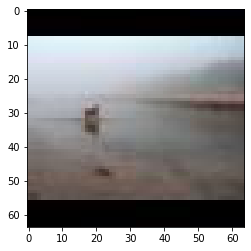

In [17]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 
data = X_test[45]
plt.imshow(data, interpolation='nearest')
plt.show()

In [0]:
#EMB_SHAPE = 1024
EMB_SHAPE = 768

def generate_c(x):
    mean = x[:, :128]
    log_sigma = x[:, 128:]
    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean
    return c
  
def build_ca_model():
    """
    Get conditioning augmentation model.
    Takes an embedding of shape (1024,) and returns a tensor of shape (256,)
    """
    input_layer = Input(shape=(EMB_SHAPE,))
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model
  
def build_embedding_compressor_model():
    """
    Build embedding compressor model
    """
    input_layer = Input(shape=(EMB_SHAPE,))
    x = Dense(128)(input_layer)
    x = ReLU()(x)

    model = Model(inputs=[input_layer], outputs=[x])
    return model
  
def build_stage1_generator():
    """
    Builds a generator model used in Stage-I
    """
    input_layer = Input(shape=(EMB_SHAPE,))
    x = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(x)

    c = Lambda(generate_c)(mean_logsigma)

    input_layer2 = Input(shape=(100,))

    gen_input = Concatenate(axis=1)([c, input_layer2])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = ReLU()(x)

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, input_layer2], outputs=[x, mean_logsigma])
    return stage1_gen

def build_stage1_discriminator():
    """
    Create a model which takes two inputs
    1. One from above network
    2. One from the embedding layer
    3. Concatenate along the axis dimension and feed it to the last module which produces final logits
    """
    input_layer = Input(shape=(64, 64, 3))

    x = Conv2D(64, (4, 4),
               padding='same', strides=2,
               input_shape=(64, 64, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    input_layer2 = Input(shape=(4, 4, 128))

    merged_input = concatenate([x, input_layer2])

    x2 = Conv2D(64 * 8, kernel_size=1,
                padding="same", strides=1)(merged_input)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1)(x2)
    x2 = Activation('sigmoid')(x2)

    stage1_dis = Model(inputs=[input_layer, input_layer2], outputs=[x2])
    return stage1_dis
  
def build_adversarial_model(gen_model, dis_model):
    input_layer = Input(shape=(EMB_SHAPE,))
    input_layer2 = Input(shape=(100,))
    input_layer3 = Input(shape=(4, 4, 128))

    x, mean_logsigma = gen_model([input_layer, input_layer2])

    dis_model.trainable = False
    valid = dis_model([x, input_layer3])

    model = Model(inputs=[input_layer, input_layer2, input_layer3], outputs=[valid, mean_logsigma])
    return model


def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss
    

def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)


def save_rgb_img(img, path):
    """
    Save an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()
    
def write_log(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    summary = tf.Summary()
    summary_value = summary.value.add()
    summary_value.simple_value = loss
    summary_value.tag = name
    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()


def write_log2(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    writer = tf.summary.create_file_writer("/logs")
    with writer.as_default():
      tf.summary.scalar(name, loss,batch_no)
    writer.flush()

In [19]:
X_train.shape[0]

32364

In [20]:
image_size = 64
batch_size = 128
z_dim = 100
stage1_generator_lr = 0.0002
stage1_discriminator_lr = 0.0002
stage1_lr_decay_step = 600
epochs =  10000
condition_dim = 128

dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

"""
Build and compile networks
"""
ca_model = build_ca_model()
ca_model.compile(loss="binary_crossentropy", optimizer="adam")

stage1_dis = build_stage1_discriminator()
stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)
stage1_dis.load_weights("./src-paola/GRIDSEARCH/models/stage1_dis_BACTH_128_300.h5")

stage1_gen = build_stage1_generator()
stage1_gen.compile(loss="mse", optimizer=gen_optimizer)
stage1_gen.load_weights("./src-paola/GRIDSEARCH/models/stage1_gen_BACTH_128_300.h5")

embedding_compressor_model = build_embedding_compressor_model()
embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")

adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                          optimizer=gen_optimizer, metrics=None)



# Generate an array containing real and fake values
# Apply label smoothing as well
real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

for epoch in range(300,601):
    #print("========================================")
    print("Epoch is:", epoch)
    print("Number of batches", int(X_train.shape[0] / batch_size))

    gen_losses = []
    dis_losses = []

    # Load data and train model
    number_of_batches = int(X_train.shape[0] / batch_size)
    for index in range(number_of_batches):
        #print("Batch:{}".format(index+1))

        """
        Train the discriminator network
        """
        # Sample a batch of data
        z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
        image_batch = X_train[index * batch_size:(index + 1) * batch_size]
        embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size]
        lemma_batch = lemma_train[index * batch_size:(index + 1) * batch_size]
        image_batch = (image_batch - 127.5) / 127.5

        # Generate fake images
        fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)

        # Generate compressed embeddings
        compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch)
        compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim))
        compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

        dis_loss_real = stage1_dis.train_on_batch([image_batch, compressed_embedding],
                                                  np.reshape(real_labels, (batch_size, 1)))
        dis_loss_fake = stage1_dis.train_on_batch([fake_images, compressed_embedding],
                                                  np.reshape(fake_labels, (batch_size, 1)))
        dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)], compressed_embedding[1:]],
                                                   np.reshape(fake_labels[1:], (batch_size-1, 1)))

        d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

        #print("d_loss_real:{}".format(dis_loss_real))
        #print("d_loss_fake:{}".format(dis_loss_fake))
        #print("d_loss_wrong:{}".format(dis_loss_wrong))
        #print("d_loss:{}".format(d_loss))

        """
        Train the generator network 
        """
        g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])
        #print("g_loss:{}".format(g_loss))

        dis_losses.append(d_loss)
        gen_losses.append(g_loss)
         # Generate and save images after every 2nd epoch

    if epoch % 10 == 0:
        # z_noise2 = np.random.uniform(-1, 1, size=(batch_size, z_dim))

        # GUARDA TRAIN
        for i, img in enumerate(fake_images):
            save_rgb_img(img, "./src-paola/GRIDSEARCH/results/find_best/train/gen_2_{}_{}_{}.png".format(epoch, lemma_batch[i], i+128*index))

        z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
        embedding_batch = embeddings_test[0:batch_size]
        lemma_batch_test = lemma_test[0:batch_size]
        fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

        # GUARDA TEST
        for i, img in enumerate(fake_images):
            save_rgb_img(img, "./src-paola/GRIDSEARCH/results/find_best/test/gen_2_{}_{}_{}.png".format(epoch,lemma_batch_test[i], i+128*index))

        name = "./src-paola/GRIDSEARCH/results/find_best/models/stage1_2_gen_" + str(epoch) + ".h5"
        stage1_gen.save_weights(name)
        name =  "./src-paola/GRIDSEARCH/results/find_best/models/stage1_2_dis_" + str(epoch) + ".h5"
        stage1_dis.save_weights(name)



# Save models
#stage1_gen.save_weights("./src-paola/models/BERT_noprepro/stage1_gen_FINAL.h5")
#stage1_dis.save_weights("./src-paola/models/BERT_noprepro/stage1_dis_FINAL.h5")

Epoch is: 300
Number of batches 252


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow w

Epoch is: 301
Number of batches 252
Epoch is: 302
Number of batches 252
Epoch is: 303
Number of batches 252
Epoch is: 304
Number of batches 252
Epoch is: 305
Number of batches 252
Epoch is: 306
Number of batches 252
Epoch is: 307
Number of batches 252
Epoch is: 308
Number of batches 252
Epoch is: 309
Number of batches 252
Epoch is: 310
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 311
Number of batches 252
Epoch is: 312
Number of batches 252
Epoch is: 313
Number of batches 252
Epoch is: 314
Number of batches 252
Epoch is: 315
Number of batches 252
Epoch is: 316
Number of batches 252
Epoch is: 317
Number of batches 252
Epoch is: 318
Number of batches 252
Epoch is: 319
Number of batches 252
Epoch is: 320
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 321
Number of batches 252
Epoch is: 322
Number of batches 252
Epoch is: 323
Number of batches 252
Epoch is: 324
Number of batches 252
Epoch is: 325
Number of batches 252
Epoch is: 326
Number of batches 252
Epoch is: 327
Number of batches 252
Epoch is: 328
Number of batches 252
Epoch is: 329
Number of batches 252
Epoch is: 330
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 331
Number of batches 252
Epoch is: 332
Number of batches 252
Epoch is: 333
Number of batches 252
Epoch is: 334
Number of batches 252
Epoch is: 335
Number of batches 252
Epoch is: 336
Number of batches 252
Epoch is: 337
Number of batches 252
Epoch is: 338
Number of batches 252
Epoch is: 339
Number of batches 252
Epoch is: 340
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 341
Number of batches 252
Epoch is: 342
Number of batches 252
Epoch is: 343
Number of batches 252
Epoch is: 344
Number of batches 252
Epoch is: 345
Number of batches 252
Epoch is: 346
Number of batches 252
Epoch is: 347
Number of batches 252
Epoch is: 348
Number of batches 252
Epoch is: 349
Number of batches 252
Epoch is: 350
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 351
Number of batches 252
Epoch is: 352
Number of batches 252
Epoch is: 353
Number of batches 252
Epoch is: 354
Number of batches 252
Epoch is: 355
Number of batches 252
Epoch is: 356
Number of batches 252
Epoch is: 357
Number of batches 252
Epoch is: 358
Number of batches 252
Epoch is: 359
Number of batches 252
Epoch is: 360
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 361
Number of batches 252
Epoch is: 362
Number of batches 252
Epoch is: 363
Number of batches 252
Epoch is: 364
Number of batches 252
Epoch is: 365
Number of batches 252
Epoch is: 366
Number of batches 252
Epoch is: 367
Number of batches 252
Epoch is: 368
Number of batches 252
Epoch is: 369
Number of batches 252
Epoch is: 370
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 371
Number of batches 252
Epoch is: 372
Number of batches 252
Epoch is: 373
Number of batches 252
Epoch is: 374
Number of batches 252
Epoch is: 375
Number of batches 252
Epoch is: 376
Number of batches 252
Epoch is: 377
Number of batches 252
Epoch is: 378
Number of batches 252
Epoch is: 379
Number of batches 252
Epoch is: 380
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 381
Number of batches 252
Epoch is: 382
Number of batches 252
Epoch is: 383
Number of batches 252
Epoch is: 384
Number of batches 252
Epoch is: 385
Number of batches 252
Epoch is: 386
Number of batches 252
Epoch is: 387
Number of batches 252
Epoch is: 388
Number of batches 252
Epoch is: 389
Number of batches 252
Epoch is: 390
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 391
Number of batches 252
Epoch is: 392
Number of batches 252
Epoch is: 393
Number of batches 252
Epoch is: 394
Number of batches 252
Epoch is: 395
Number of batches 252
Epoch is: 396
Number of batches 252
Epoch is: 397
Number of batches 252
Epoch is: 398
Number of batches 252
Epoch is: 399
Number of batches 252
Epoch is: 400
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 401
Number of batches 252
Epoch is: 402
Number of batches 252
Epoch is: 403
Number of batches 252
Epoch is: 404
Number of batches 252
Epoch is: 405
Number of batches 252
Epoch is: 406
Number of batches 252
Epoch is: 407
Number of batches 252
Epoch is: 408
Number of batches 252
Epoch is: 409
Number of batches 252
Epoch is: 410
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 411
Number of batches 252
Epoch is: 412
Number of batches 252
Epoch is: 413
Number of batches 252
Epoch is: 414
Number of batches 252
Epoch is: 415
Number of batches 252
Epoch is: 416
Number of batches 252
Epoch is: 417
Number of batches 252
Epoch is: 418
Number of batches 252
Epoch is: 419
Number of batches 252
Epoch is: 420
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 421
Number of batches 252
Epoch is: 422
Number of batches 252
Epoch is: 423
Number of batches 252
Epoch is: 424
Number of batches 252
Epoch is: 425
Number of batches 252
Epoch is: 426
Number of batches 252
Epoch is: 427
Number of batches 252
Epoch is: 428
Number of batches 252
Epoch is: 429
Number of batches 252
Epoch is: 430
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 431
Number of batches 252
Epoch is: 432
Number of batches 252
Epoch is: 433
Number of batches 252
Epoch is: 434
Number of batches 252
Epoch is: 435
Number of batches 252
Epoch is: 436
Number of batches 252
Epoch is: 437
Number of batches 252
Epoch is: 438
Number of batches 252
Epoch is: 439
Number of batches 252
Epoch is: 440
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 441
Number of batches 252
Epoch is: 442
Number of batches 252
Epoch is: 443
Number of batches 252
Epoch is: 444
Number of batches 252
Epoch is: 445
Number of batches 252
Epoch is: 446
Number of batches 252
Epoch is: 447
Number of batches 252
Epoch is: 448
Number of batches 252
Epoch is: 449
Number of batches 252
Epoch is: 450
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 451
Number of batches 252
Epoch is: 452
Number of batches 252
Epoch is: 453
Number of batches 252
Epoch is: 454
Number of batches 252
Epoch is: 455
Number of batches 252
Epoch is: 456
Number of batches 252
Epoch is: 457
Number of batches 252
Epoch is: 458
Number of batches 252
Epoch is: 459
Number of batches 252
Epoch is: 460
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 461
Number of batches 252
Epoch is: 462
Number of batches 252
Epoch is: 463
Number of batches 252
Epoch is: 464
Number of batches 252
Epoch is: 465
Number of batches 252
Epoch is: 466
Number of batches 252
Epoch is: 467
Number of batches 252
Epoch is: 468
Number of batches 252
Epoch is: 469
Number of batches 252
Epoch is: 470
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 471
Number of batches 252
Epoch is: 472
Number of batches 252
Epoch is: 473
Number of batches 252
Epoch is: 474
Number of batches 252
Epoch is: 475
Number of batches 252
Epoch is: 476
Number of batches 252
Epoch is: 477
Number of batches 252
Epoch is: 478
Number of batches 252
Epoch is: 479
Number of batches 252
Epoch is: 480
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 481
Number of batches 252
Epoch is: 482
Number of batches 252
Epoch is: 483
Number of batches 252
Epoch is: 484
Number of batches 252
Epoch is: 485
Number of batches 252
Epoch is: 486
Number of batches 252
Epoch is: 487
Number of batches 252
Epoch is: 488
Number of batches 252
Epoch is: 489
Number of batches 252
Epoch is: 490
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 491
Number of batches 252
Epoch is: 492
Number of batches 252
Epoch is: 493
Number of batches 252
Epoch is: 494
Number of batches 252
Epoch is: 495
Number of batches 252
Epoch is: 496
Number of batches 252
Epoch is: 497
Number of batches 252
Epoch is: 498
Number of batches 252
Epoch is: 499
Number of batches 252
Epoch is: 500
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 501
Number of batches 252
Epoch is: 502
Number of batches 252
Epoch is: 503
Number of batches 252
Epoch is: 504
Number of batches 252
Epoch is: 505
Number of batches 252
Epoch is: 506
Number of batches 252
Epoch is: 507
Number of batches 252
Epoch is: 508
Number of batches 252
Epoch is: 509
Number of batches 252
Epoch is: 510
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 511
Number of batches 252
Epoch is: 512
Number of batches 252
Epoch is: 513
Number of batches 252
Epoch is: 514
Number of batches 252
Epoch is: 515
Number of batches 252
Epoch is: 516
Number of batches 252
Epoch is: 517
Number of batches 252
Epoch is: 518
Number of batches 252
Epoch is: 519
Number of batches 252
Epoch is: 520
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 521
Number of batches 252
Epoch is: 522
Number of batches 252
Epoch is: 523
Number of batches 252
Epoch is: 524
Number of batches 252
Epoch is: 525
Number of batches 252
Epoch is: 526
Number of batches 252
Epoch is: 527
Number of batches 252
Epoch is: 528
Number of batches 252
Epoch is: 529
Number of batches 252
Epoch is: 530
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 531
Number of batches 252
Epoch is: 532
Number of batches 252
Epoch is: 533
Number of batches 252
Epoch is: 534
Number of batches 252
Epoch is: 535
Number of batches 252
Epoch is: 536
Number of batches 252
Epoch is: 537
Number of batches 252
Epoch is: 538
Number of batches 252
Epoch is: 539
Number of batches 252
Epoch is: 540
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 541
Number of batches 252
Epoch is: 542
Number of batches 252
Epoch is: 543
Number of batches 252
Epoch is: 544
Number of batches 252
Epoch is: 545
Number of batches 252
Epoch is: 546
Number of batches 252
Epoch is: 547
Number of batches 252
Epoch is: 548
Number of batches 252
Epoch is: 549
Number of batches 252
Epoch is: 550
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 551
Number of batches 252
Epoch is: 552
Number of batches 252
Epoch is: 553
Number of batches 252
Epoch is: 554
Number of batches 252
Epoch is: 555
Number of batches 252
Epoch is: 556
Number of batches 252
Epoch is: 557
Number of batches 252
Epoch is: 558
Number of batches 252
Epoch is: 559
Number of batches 252
Epoch is: 560
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 561
Number of batches 252
Epoch is: 562
Number of batches 252
Epoch is: 563
Number of batches 252
Epoch is: 564
Number of batches 252
Epoch is: 565
Number of batches 252
Epoch is: 566
Number of batches 252
Epoch is: 567
Number of batches 252
Epoch is: 568
Number of batches 252
Epoch is: 569
Number of batches 252
Epoch is: 570
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 571
Number of batches 252
Epoch is: 572
Number of batches 252
Epoch is: 573
Number of batches 252
Epoch is: 574
Number of batches 252
Epoch is: 575
Number of batches 252
Epoch is: 576
Number of batches 252
Epoch is: 577
Number of batches 252
Epoch is: 578
Number of batches 252
Epoch is: 579
Number of batches 252
Epoch is: 580
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 581
Number of batches 252
Epoch is: 582
Number of batches 252
Epoch is: 583
Number of batches 252
Epoch is: 584
Number of batches 252
Epoch is: 585
Number of batches 252
Epoch is: 586
Number of batches 252
Epoch is: 587
Number of batches 252
Epoch is: 588
Number of batches 252
Epoch is: 589
Number of batches 252
Epoch is: 590
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 591
Number of batches 252
Epoch is: 592
Number of batches 252
Epoch is: 593
Number of batches 252
Epoch is: 594
Number of batches 252
Epoch is: 595
Number of batches 252
Epoch is: 596
Number of batches 252
Epoch is: 597
Number of batches 252
Epoch is: 598
Number of batches 252
Epoch is: 599
Number of batches 252
Epoch is: 600
Number of batches 252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [0]:
import pandas as pd
import numpy as np

array_gen = np.array(results_gen)
array_dis = np.array(results_dis)
res = pd.DataFrame({"gen": array_gen[:, 0], "dis":array_dis[:, 0], "capas":2})
name = "./src-paola/GRIDSEARCH/losses/batch128.csv"
res.to_csv(name)
